<a href="https://colab.research.google.com/github/Nekoiii/ML_Practices_colab/blob/main/image_classification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
import os
import cv2
import numpy as np
import glob as glob #glob module is used to search for files that match a specific file pattern or name. It can be used to search CSV files and for text in files. 
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

#Use the folder name as the class name.
path='/content/gdrive/MyDrive/datasets/imgs/powerLines_classification/'
folders=os.listdir(path)
classes= [f for f in folders if (os.path.isdir(os.path.join(path,f)) and not f.startswith('.'))]
n_classes=len(classes)

print(classes,n_classes)

['with_powerlines', 'without_powerlines'] 2


In [56]:
import os
current_path = os.getcwd()
print(current_path)

/content/gdrive/MyDrive/datasets/imgs/powerLines_classification


In [57]:
img=cv2.imread(image_path)
img=cv2.resize(img,dsize=(224,224))

#img

In [58]:
X=[]
y=[]


lens=[]
for class_name in classes:
    lens.append( len(glob.glob(class_name + '/*.jpg')) )
min_samples = min(lens)


for label,class_name in enumerate(classes):
  files=glob.glob(class_name+'/*.jpg')
  #limit sample size (balance the number of samples for each classe)
  files = files[:min_samples] 

  for file in files: 
    #print(file)
    img=cv2.imread(file)
    if img is None:
      print('Failed to read the image: ',file)
    try: 
      img=cv2.resize(img,dsize=(224,224))
    except Exception as e:
      print("Error occurred while resizing the image:", e)
    
    X.append((img))
    y.append(label)
    
  print(X[0])
    

[[[253 253 250]
  [247 252 253]
  [243 252 255]
  ...
  [250 253 254]
  [252 251 253]
  [252 252 252]]

 [[253 253 250]
  [247 252 253]
  [243 252 255]
  ...
  [250 253 254]
  [252 251 253]
  [252 252 252]]

 [[253 253 250]
  [247 252 253]
  [243 252 255]
  ...
  [250 253 254]
  [252 251 253]
  [252 252 252]]

 ...

 [[255 252 250]
  [249 251 254]
  [244 251 255]
  ...
  [251 252 250]
  [252 252 252]
  [252 252 252]]

 [[254 252 250]
  [248 251 254]
  [247 250 255]
  ...
  [249 251 251]
  [250 252 252]
  [250 252 252]]

 [[254 252 250]
  [249 251 254]
  [247 250 255]
  ...
  [249 251 251]
  [250 252 252]
  [250 252 252]]]
[[[253 253 250]
  [247 252 253]
  [243 252 255]
  ...
  [250 253 254]
  [252 251 253]
  [252 252 252]]

 [[253 253 250]
  [247 252 253]
  [243 252 255]
  ...
  [250 253 254]
  [252 251 253]
  [252 252 252]]

 [[253 253 250]
  [247 252 253]
  [243 252 255]
  ...
  [250 253 254]
  [252 251 253]
  [252 252 252]]

 ...

 [[255 252 250]
  [249 251 254]
  [244 251 255]
  ..

In [59]:
X=np.array(X)
X=X.astype('float32')
X /= 255
X[0]

array([[[0.992, 0.992, 0.98 ],
        [0.969, 0.988, 0.992],
        [0.953, 0.988, 1.   ],
        ...,
        [0.98 , 0.992, 0.996],
        [0.988, 0.984, 0.992],
        [0.988, 0.988, 0.988]],

       [[0.992, 0.992, 0.98 ],
        [0.969, 0.988, 0.992],
        [0.953, 0.988, 1.   ],
        ...,
        [0.98 , 0.992, 0.996],
        [0.988, 0.984, 0.992],
        [0.988, 0.988, 0.988]],

       [[0.992, 0.992, 0.98 ],
        [0.969, 0.988, 0.992],
        [0.953, 0.988, 1.   ],
        ...,
        [0.98 , 0.992, 0.996],
        [0.988, 0.984, 0.992],
        [0.988, 0.988, 0.988]],

       ...,

       [[1.   , 0.988, 0.98 ],
        [0.976, 0.984, 0.996],
        [0.957, 0.984, 1.   ],
        ...,
        [0.984, 0.988, 0.98 ],
        [0.988, 0.988, 0.988],
        [0.988, 0.988, 0.988]],

       [[0.996, 0.988, 0.98 ],
        [0.973, 0.984, 0.996],
        [0.969, 0.98 , 1.   ],
        ...,
        [0.976, 0.984, 0.984],
        [0.98 , 0.988, 0.988],
        [0.98 ,

In [60]:
unique_elements = set(y) 
counts = {element: y.count(element) for element in unique_elements}
print(counts)

{0: 368, 1: 368}


In [61]:
y-np.array(y)
y=np_utils.to_categorical(y,n_classes)
y[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [62]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(588, 224, 224, 3) (148, 224, 224, 3) (588, 2) (148, 2)


In [63]:
# VGG16: a convolution neural network (CNN) model supporting 16 layers
from keras.applications.vgg16 import VGG16  
# Sequential model: https://keras.io/guides/sequential_model/
# Sequential vs Model: https://stackoverflow.com/questions/66879748/what-is-the-difference-between-tf-keras-model-and-tf-keras-sequential
from keras.models import Sequential
from keras.models import Model
# model_from_json： loads a model structure from a JSON file or JSON string,and converts the JSON representation of a model into a Keras model object.
from keras.models import model_from_json
#Dropout: used for regularization and preventing overfitting in a neural network. It randomly sets a fraction of input units to 0 during training, which helps to prevent the network from relying too heavily on any single input feature.
from keras.layers import Input,Activation,Concatenate,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam


In [64]:
input_tensor= Input(shape=(224,224,3))
# include_top=False: exclude the top (fully connected) layers of the network from the model
base_model=VGG16(weights='imagenet',input_tensor=input_tensor,include_top=False)

#create the top layer 
top_model=Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(n_classes,activation='softmax'))

#combine base_model and top_model
model=Model(inputs=base_model.input,outputs=top_model(base_model.output))

#By freezing the weights of the first 15 layers, we can preserve the learned low-level features such as edge detection and texture that are generally applicable to many image classification tasks. 
#This prevents overfitting and speeds up training since these lower layers are already effective in capturing important visual patterns.
for layer in model.layers[:15]:
  layer.trainable=False

print('#layers_len=',len(model.layers))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#print a useful summary of the model
model.summary()


#layers_len= 20
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56,

In [65]:
model.fit(X_train,y_train,epochs=20,batch_size=16)

score=model.evaluate(X_test,y_test,batch_size=16)

Epoch 1/20
37/37 [==============================] - 5s 79ms/step - loss: 0.5248 - accuracy: 0.7721
Epoch 2/20
37/37 [==============================] - 3s 76ms/step - loss: 0.2225 - accuracy: 0.9337
Epoch 3/20
37/37 [==============================] - 3s 76ms/step - loss: 0.2381 - accuracy: 0.9388
Epoch 4/20
37/37 [==============================] - 3s 76ms/step - loss: 0.1040 - accuracy: 0.9694
Epoch 5/20
37/37 [==============================] - 3s 79ms/step - loss: 0.0504 - accuracy: 0.9898
Epoch 6/20
37/37 [==============================] - 3s 76ms/step - loss: 0.0385 - accuracy: 0.9932
Epoch 7/20
37/37 [==============================] - 3s 76ms/step - loss: 0.2589 - accuracy: 0.9779
Epoch 8/20
37/37 [==============================] - 3s 76ms/step - loss: 0.6911 - accuracy: 0.9371
Epoch 9/20
37/37 [==============================] - 3s 78ms/step - loss: 0.3325 - accuracy: 0.9490
Epoch 10/20
37/37 [==============================] - 3s 78ms/step - loss: 0.2873 - accuracy: 0.9728
Epoch 11/

In [66]:
import pickle
pickle.dump(classes, open('./classes.sav', 'wb'))
model.save('./cnn_test_1.h5')


In [67]:
from keras.models import load_model
import pickle
import cv2

model=load_model('./cnn_test_1.h5')
classes=pickle.load(open('./classes.sav','rb'))

In [68]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
#jump into the dataset folder
%cd '/content/gdrive/MyDrive/ML_Practices/VGG16/'

/content/gdrive/MyDrive/ML_Practices/VGG16


In [73]:
!pwd


/content/gdrive/MyDrive/ML_Practices/VGG16


In [88]:
PREDICT_MODE='SINGLE_IMG'  #'SINGLE_IMG','ALL_IMGS'

predict_folder='./predict_imgs/'

image_files=[]
if PREDICT_MODE=='SINGLE_IMG':
  image_files = glob.glob(predict_folder+'*.jpg') + glob.glob(predict_folder+'*.png')
elif PREDICT_MODE=='ALL_IMGS':
  image_files.append('./predict_imgs/test_8.jpg')

['./predict_imgs/test_1.jpg', './predict_imgs/test_2.jpg', './predict_imgs/test_3.jpg', './predict_imgs/test_4.jpg', './predict_imgs/test_5.jpg', './predict_imgs/test_6.jpg', './predict_imgs/test_7.jpg', './predict_imgs/test_8.jpg', './predict_imgs/test_9.jpg', './predict_imgs/test_11.jpg', './predict_imgs/test_10.jpg', './predict_imgs/test_12.png', './predict_imgs/noodles_4.png', './predict_imgs/noodles_3.png', './predict_imgs/noodles_2.png', './predict_imgs/noodles_1.png', './predict_imgs/test_13.png', './predict_imgs/noodles_6.png', './predict_imgs/noodles_5.png', './predict_imgs/test_14.png', './predict_imgs/test_15.png']


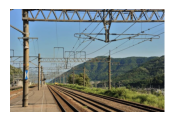

1/1 [==============================] - 0s 23ms/step
[[100.   0.]]
with_powerlines


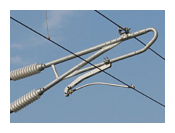

1/1 [==============================] - 0s 30ms/step
[[100.   0.]]
with_powerlines


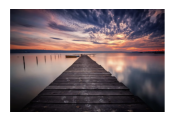

1/1 [==============================] - 0s 22ms/step
[[  0. 100.]]
without_powerlines


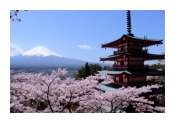

1/1 [==============================] - 0s 31ms/step
[[  0. 100.]]
without_powerlines


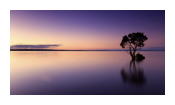

1/1 [==============================] - 0s 29ms/step
[[  0. 100.]]
without_powerlines


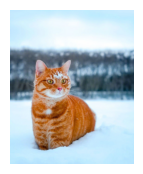

1/1 [==============================] - 0s 28ms/step
[[  0. 100.]]
without_powerlines


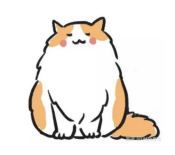

1/1 [==============================] - 0s 30ms/step
[[  0. 100.]]
without_powerlines


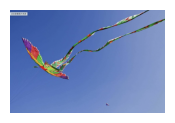

1/1 [==============================] - 0s 40ms/step
[[  0. 100.]]
without_powerlines


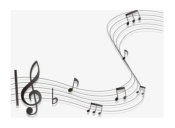

1/1 [==============================] - 0s 39ms/step
[[100.   0.]]
with_powerlines


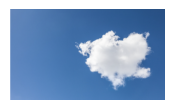

1/1 [==============================] - 0s 27ms/step
[[  0. 100.]]
without_powerlines


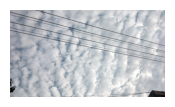

1/1 [==============================] - 0s 25ms/step
[[100.   0.]]
with_powerlines


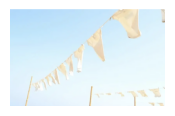

1/1 [==============================] - 0s 20ms/step
[[  0. 100.]]
without_powerlines


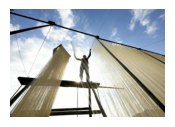

1/1 [==============================] - 0s 19ms/step
[[100.   0.]]
with_powerlines


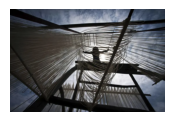

1/1 [==============================] - 0s 30ms/step
[[  0. 100.]]
without_powerlines


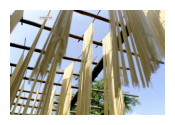

1/1 [==============================] - 0s 25ms/step
[[100.   0.]]
with_powerlines


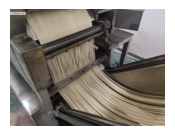

1/1 [==============================] - 0s 25ms/step
[[  0. 100.]]
without_powerlines


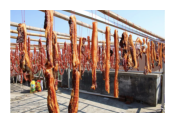

1/1 [==============================] - 0s 20ms/step
[[  0. 100.]]
without_powerlines


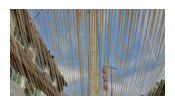

1/1 [==============================] - 0s 19ms/step
[[  0. 100.]]
without_powerlines


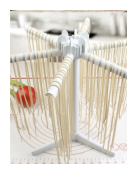

1/1 [==============================] - 0s 21ms/step
[[  0. 100.]]
without_powerlines


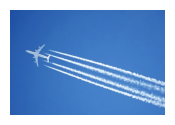

1/1 [==============================] - 0s 20ms/step
[[  0. 100.]]
without_powerlines


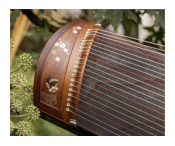

1/1 [==============================] - 0s 22ms/step
[[100.   0.]]
with_powerlines


In [89]:

from matplotlib import pyplot as plt
print(image_files)

np.set_printoptions(precision=3,suppress=True)
for file_name in image_files:
  img=cv2.imread(file_name)
  if img is None:
    print('Can\'t find this file:',file_name)
    break

  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

  plt.figure(figsize=(2,2)) 
  plt.imshow(img_rgb)
  plt.axis('off') 
  plt.show()

  img=cv2.resize(img,dsize=(224,224))
  img=img.astype('float32')
  img/=255.0
  #To handle the case of only a single prediction image, add a batch dimension to the 'img' array.
  img=img[None,...]

  result=model.predict(img)  
  print(result * 100)
  pred = result.argmax()
  print(classes[pred])

